# Preparation For Topic Modelling

Eventually to include tf-idf threshold

In [1]:
import os
import pandas as pd
from nltk import word_tokenize, wordpunct_tokenize
from nltk.stem import PorterStemmer
from gensim.corpora import Dictionary
import string
import math
import matplotlib.pyplot as plt

import setup_modules
from lib.fomc import init_fomc, get_fomc, get_lname
from lib.preprocessing import process

In [2]:
tdf = pd.read_csv('working-csvs/raw_transcripts_sectioned.csv', index_col=0)

In [3]:
prdf, bog = init_fomc('fomc-membership/presidents.csv', 'fomc-membership/bog.csv')

In [5]:
tdf['lname'] = tdf['speaker'].map(get_lname)

In [6]:
tdf['is_fomc'] = tdf[['lname', 'date']].apply(lambda x : x.lname in get_fomc(x.date, prdf, bog), axis=1)

In [13]:
tdf[tdf['is_fomc'] == True].reset_index(drop=True).drop(columns='is_fomc').to_csv('working-csvs/fomc_sectioned.csv')

**Run Bigram and trigram detection here**

In [4]:
tdf = pd.read_csv('./working-csvs/fomc_sectioned.csv', index_col=0)

## Bi and Trigram enhancements

In [5]:
bigrams = set()

with open(os.path.join('ngrams', 'bigrams')) as bg_file:
    for bg in bg_file.readlines():
        bigrams.add(bg.strip())

In [6]:
trigrams = set()

with open(os.path.join('ngrams', 'trigrams')) as tg_file:
    for tf in tg_file.readlines():
        trigrams.add(tf.strip())

In [7]:
def ngram_enhance(raw_string):
    to_add = []
    raw_string = str(raw_string)
    for bg in bigrams:
        if str(bg) in raw_string.lower():
            to_add.append('_'.join(bg.split(' ')))
    for tg in trigrams:
        if str(tg) in raw_string.lower():
            to_add.append('_'.join(tg.split(' ')))

    return raw_string + ' ' + ' '.join(to_add)

In [8]:
tdf['text_enhanced'] = tdf['content'].apply(ngram_enhance)

In [9]:
tdf.to_csv('working-csvs/fomc_sectioned_enhanced.csv')

## Create Speaker-Meeting observations

In [13]:
tdf_e = pd.read_csv('working-csvs/fomc_sectioned_enhanced.csv')

In [14]:
tdf_e['type'].value_counts()

type
meeting    25992
Name: count, dtype: int64

In [16]:
stemmer = PorterStemmer()
stopwords = []
with open('stopwords/StopWords_DatesandNumbers.txt') as f:
    lines = [line.split('|')[0].strip().lower() for line in f]
    stopwords.extend(lines)
with open('stopwords/StopWords_GenericLong.txt') as f:
    lines = [line.strip().lower() for line in f]
    stopwords.extend(lines)
stopwords = [word for word in stopwords if len(word) > 1]
stopwords.extend(['i', 'don'])

In [17]:
tdf_e['tokens'] = tdf_e['text_enhanced'].apply(lambda x : process(x, stemmer=stemmer, stopwords=stopwords)) 

In [18]:
texts = tdf_e['tokens'].tolist()
dictionary = Dictionary(texts)
len(dictionary)

14189

In [19]:
count = 0

freqs = {}
doc_appears = {}

for text in texts:
    for token, freq in dictionary.doc2bow(text):
        if token in freqs:
            freqs[token] += freq
        else:
            freqs[token] = freq
        if token in doc_appears:
            doc_appears[token] += 1
        else:
            doc_appears[token] = 1
    count +=1

In [20]:
idf = {i: math.log(len(texts) / doc_appears[i]) for i in range(len(dictionary))}
tfidf_global = {i: idf[i] * (1 + math.log(freqs[i])) for i in range(len(dictionary))}
tfidf_vals = sorted([rank for rank in tfidf_global.values()], reverse=True)

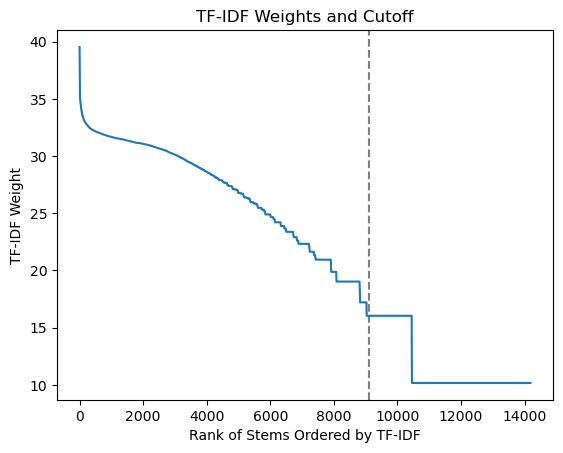

In [28]:
fig, ax = plt.subplots()

ax.set_title('TF-IDF Weights and Cutoff')

ax.axvline(x=9100, color='gray', linestyle='--')
ax.set_xlabel('Rank of Stems Ordered by TF-IDF')
ax.set_ylabel('TF-IDF Weight')

ax.plot(tfidf_vals)

In [30]:
tokens_to_keep = [i for i, tfidf in tfidf_global.items() if tfidf > tfidf_vals[9000]]
len(tokens_to_keep)

8823

In [31]:
dictionary.filter_tokens(good_ids=tokens_to_keep)
dictionary.compactify()
len(dictionary)

8823

In [32]:
dictionary.save('./models/02-27/02-27dict')

In [33]:
speaker_grouped = tdf_e.groupby(['date', 'speaker'])['text_enhanced'].agg(' '.join).reset_index()

In [34]:
speaker_grouped.to_csv('working-csvs/fomc_sectioned_speaker_grouped.csv')